In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [3]:
filename = 'bicycle.txt'
X = torch.empty((0, 2))

with open(filename, 'r') as file:
    for line in file:
        x, y = map(float, line.split())  
        point = torch.tensor([[x, y]]) 
        X = torch.cat((X, point), dim=0) 

print(X)
print(len(X))


tensor([[ 0.2370,  1.0000],
        [ 0.2399,  1.0000],
        [ 0.2428,  1.0000],
        ...,
        [ 0.6705, -0.9954],
        [ 0.6734, -0.9954],
        [ 0.6358, -1.0000]])
50468


In [4]:
def draw_points(X):
    X = X.cpu()
    x = X[:, 0] 
    y = X[:, 1]
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()
    
def draw_points_from_xy(x, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(True)
    plt.show()

In [5]:
import numpy as np

def draw_multiple_stages(X_list, labels):
    num_plots = len(X_list)
    a = int(np.ceil(np.sqrt(num_plots)))
    plt.figure(figsize=(a * 4, a * 4))
    
    for i, (X, label) in enumerate(zip(X_list, labels)):
        plt.subplot(a, a, i + 1)
        x = X[:, 0]
        y = X[:, 1]
        plt.scatter(x, y, s=1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(label)
        plt.grid(True)
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5) 

    plt.tight_layout()
    plt.show()

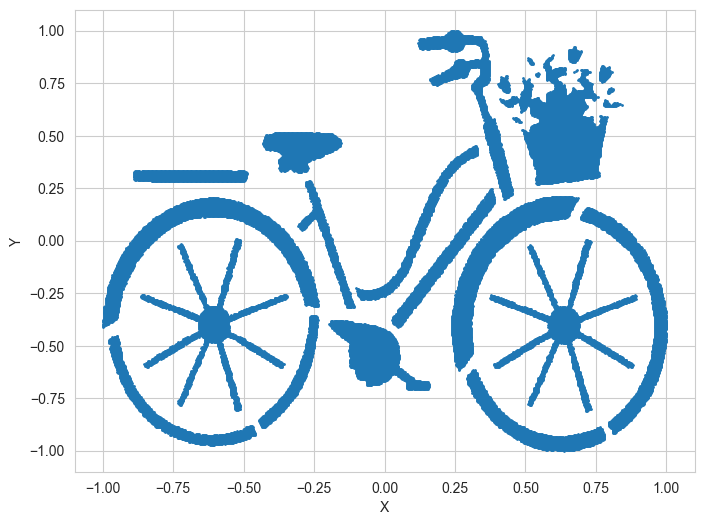

In [6]:
draw_points(X)

In [7]:
beta_1 = 1e-4
beta_T = 2e-2
T = 1000

In [8]:
def beta(t):
    return beta_1 + t * (beta_T - beta_1) / T

def alpha(t):
    return 1 - beta(t)

def alpha_seq(t):
    sequence = torch.tensor([alpha(i) for i in range(t)])
    return torch.prod(sequence, dim=0)

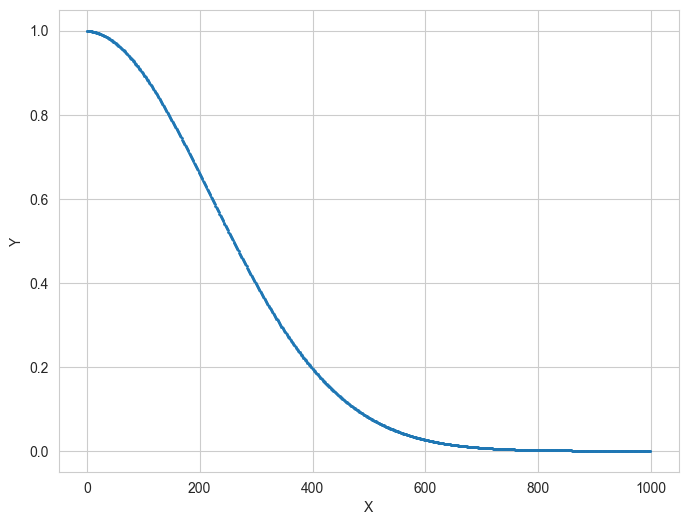

In [9]:
x = torch.arange(0, T, 1)
y = torch.tensor([alpha_seq(t) for t in range(T)])

draw_points_from_xy(x, y)

In [10]:
def alpha_sgm_c(t):
    return 1 / (1 + torch.exp(0.01 * (t - 500)))

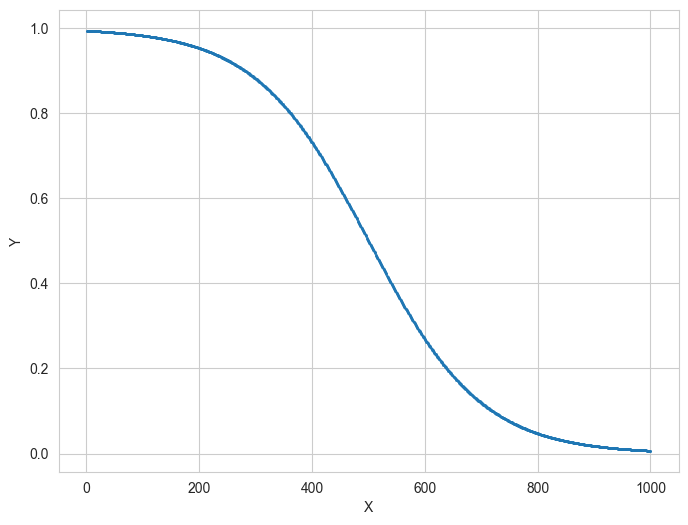

In [11]:
x = torch.linspace(1, 1000, 1000)
y = alpha_sgm_c(x)

draw_points_from_xy(x, y)

In [12]:
betas = torch.linspace(beta_1, beta_T, T+1)
alphas = 1 - betas
alpha_cumprod = torch.cumprod(alphas, dim=0)

alpha_cumprod = alpha_cumprod.to(device)
alphas = alphas.to(device)
betas = betas.to(device)


def q(t, X0, z=None):
    if type(t) == int:
        t = torch.tensor([t])
    if z is None:
        z = torch.randn_like(X0)

    mu = torch.sqrt(alpha_cumprod[t]).unsqueeze(1) * X0
    E = torch.sqrt(1 - alpha_cumprod[t]).unsqueeze(1) * z

    return mu + E

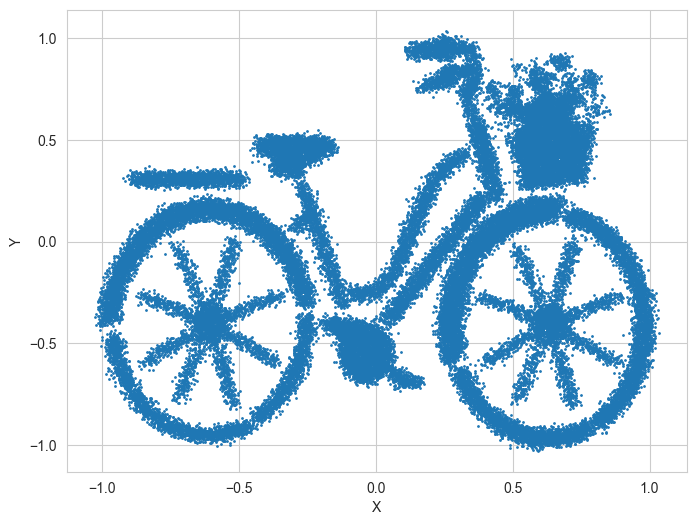

In [13]:
X1 = q(1, X.to(device))
draw_points(X1)

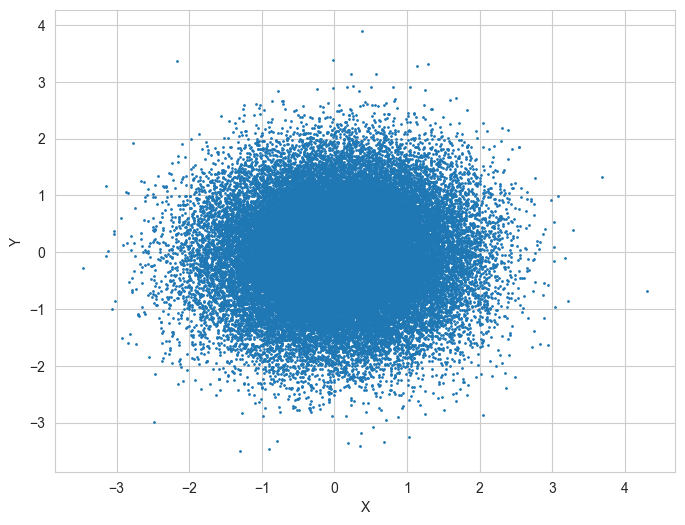

In [14]:
X1 = q(300, X.to(device))
draw_points(X1)

In [15]:
tested_t_values = list(range(0, T+1, 100))
tested_t_values[0] = 1
diffusion_progress = [q(t, X.to(device)).cpu() for t in tested_t_values]
labels = [f"t={t}" for t in tested_t_values]

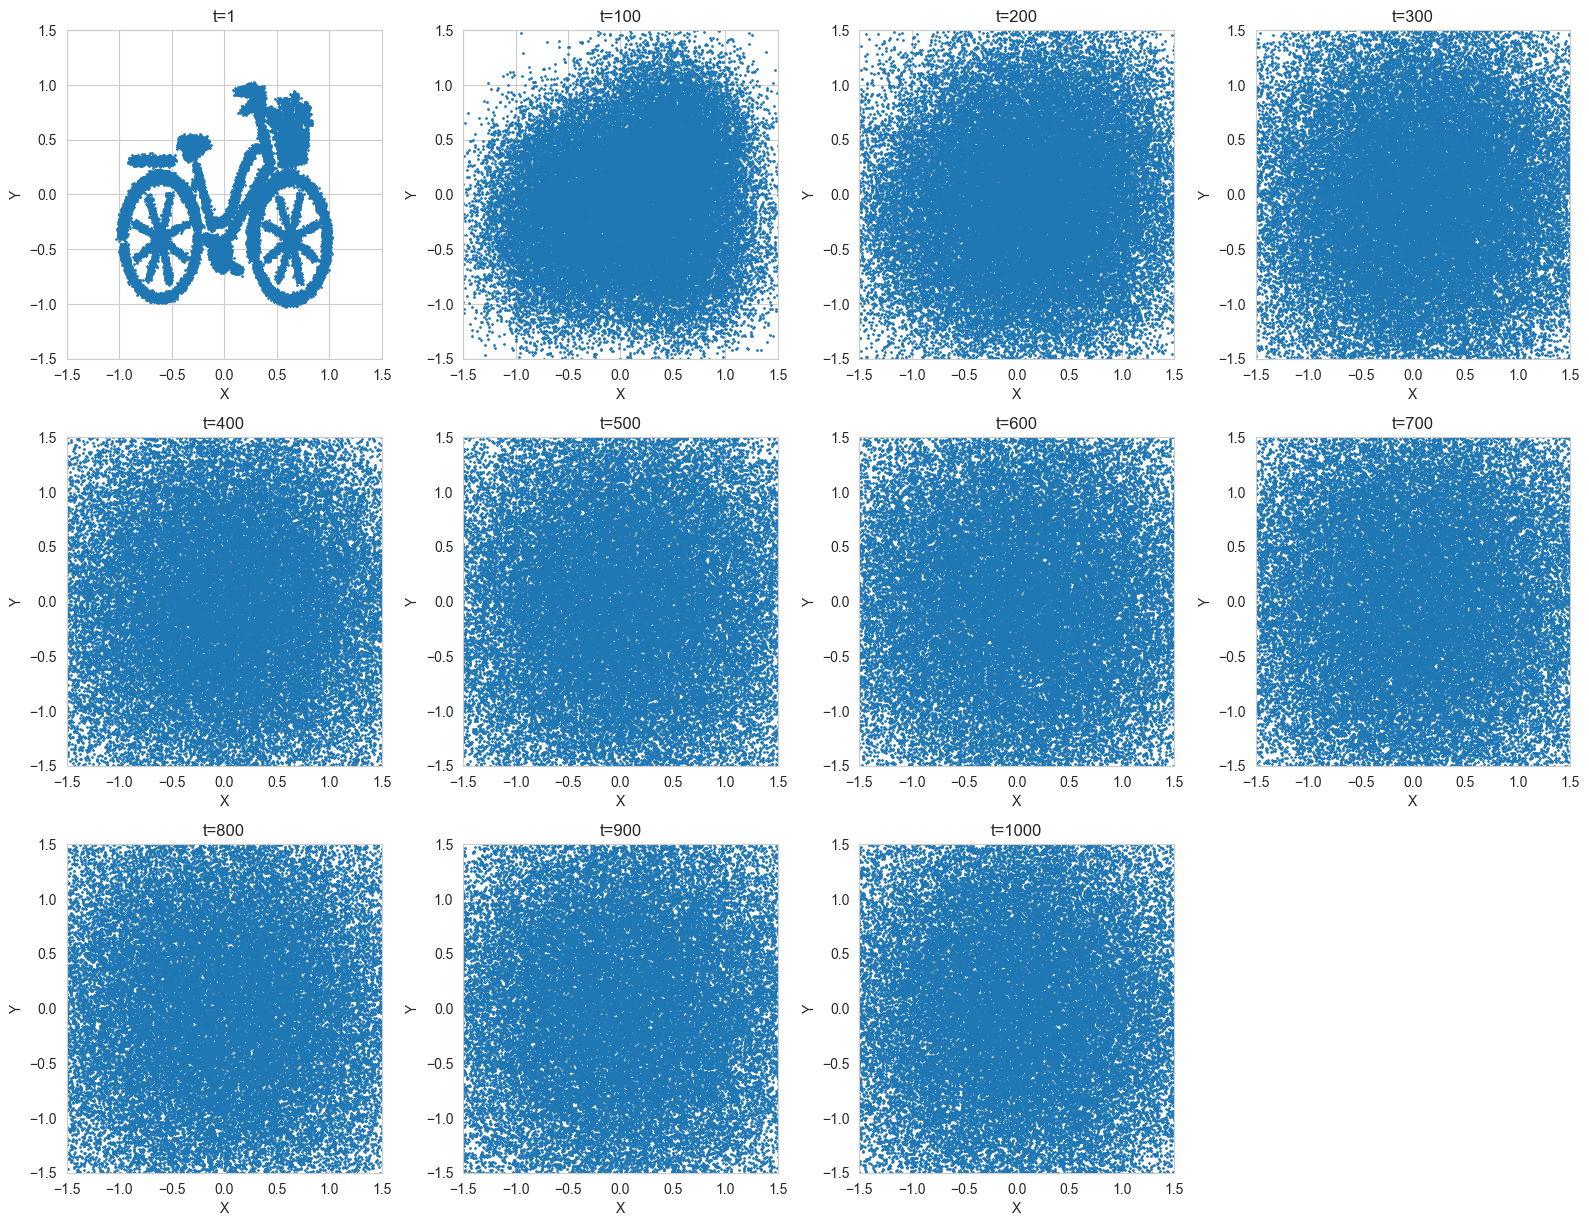

In [16]:
draw_multiple_stages(diffusion_progress, labels)

In [17]:
class LearnableSinusoidalEmbedding(nn.Module):
    def __init__(self, dim=50, seq_len=T, n=10000, dense_layer_size=128):
        # parameters
        super(LearnableSinusoidalEmbedding, self).__init__()
        self.dim = dim
        self.seq_len = seq_len
        self.n = n
        
        # positional embedding
        self.embedding = nn.Parameter(torch.zeros(seq_len, dim))
        self.__initial_embedding()
        
        # mlp
        self.mlp = nn.Sequential(
            nn.Linear(dim, dense_layer_size),
            nn.ReLU(),
            nn.Linear(dense_layer_size, dense_layer_size),
        )
        
    def forward(self, t):
        if type(t) == int:
         t = torch.tensor([t], dtype=torch.long)
        x = self.embedding[t]
        return self.mlp(x)
        

    def __initial_embedding(self):
        for k in range(self.seq_len):
            for i in np.arange(int(self.dim/2)):
                denominator = self.n ** (2*i/self.dim)
                enc_tmp = torch.tensor([k/denominator])
                self.embedding.data[k, 2*i] = torch.sin(enc_tmp)
                self.embedding.data[k, 2*i+1] = torch.cos(enc_tmp)

In [18]:
class AddEmbedding(nn.Module):
    def __init__(self, embedding):
        super().__init__()
        self.embedding = embedding
        
    def forward(self, x):
        return x + self.embedding

class DiffusionModel(nn.Module):
    def __init__(self, in_out_features=2, dense_layer_size=128):
        super(DiffusionModel, self).__init__()
        self. lse = LearnableSinusoidalEmbedding()

        self.mlp = nn.Sequential(
            nn.Linear(in_out_features, dense_layer_size),
            nn.ReLU(),
            AddEmbedding(None),

            nn.Linear(dense_layer_size, dense_layer_size),
            nn.ReLU(),
            AddEmbedding(None),

            nn.Linear(dense_layer_size, dense_layer_size),
            nn.ReLU(),
            AddEmbedding(None),

            nn.Linear(dense_layer_size, in_out_features),
        )

    def forward(self, x, t):
        embedding = self.lse(t)

        for layer in self.mlp:
            if isinstance(layer, AddEmbedding):
                layer.embedding = embedding

        return self.mlp(x)
    
    @torch.no_grad()
    def sample(self, n, verbose_steps=False):
        x = torch.randn((n, 2), device=device)
        steps = []
        for t in range(T - 1, -1, -1):
            z = torch.randn_like(x) if t >= 1 else torch.zeros_like(x)
            t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
            noise_pred = self(x, t_tensor)

            a_t = alphas[t]
            a_bar_t = alpha_cumprod[t]

            x = (1 / a_t.sqrt()) * (x - noise_pred * (1 - a_t) / (1 - a_bar_t).sqrt()) + (1 - a_t).sqrt() * z
            
            if verbose_steps:
                steps.append(torch.clone(x).cpu())
    
        return x, steps

In [19]:
def save_model(model, epoch, path="models"):
    torch.save({
        'epoch': epoch,
        'model': model.state_dict(),
    }, f"{path}/checkpoint_epoch_{epoch}.pth")

In [20]:
t = 5
x = torch.tensor([2, 3],  dtype=torch.float32).to(device)
model = DiffusionModel().to(device)
print(model(x, t).shape)

torch.Size([1, 2])


In [21]:
lr = 1e-4
batch_size = 64
verbose = 50
sample_size = 1000

In [22]:
train_loader = DataLoader(X, batch_size=batch_size, shuffle=True)

In [23]:
model = DiffusionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
epochs = 1000

In [24]:
from tqdm.notebook import tqdm

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/1000: loss 0.2513 


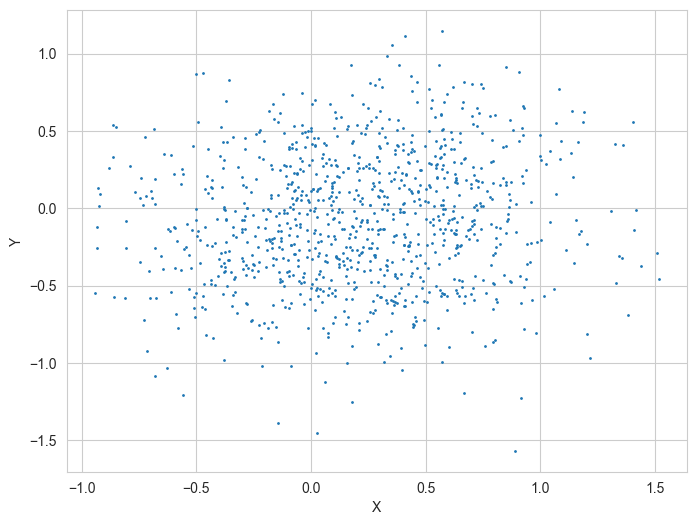

Epoch 51/1000: loss 0.1676 


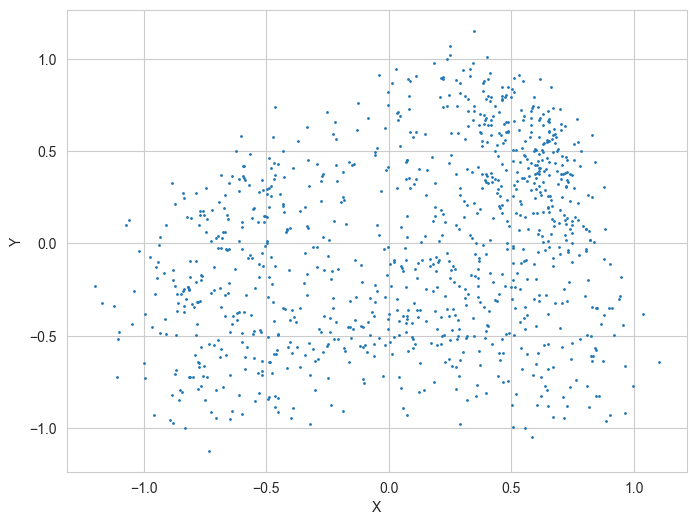

Epoch 101/1000: loss 0.1675 


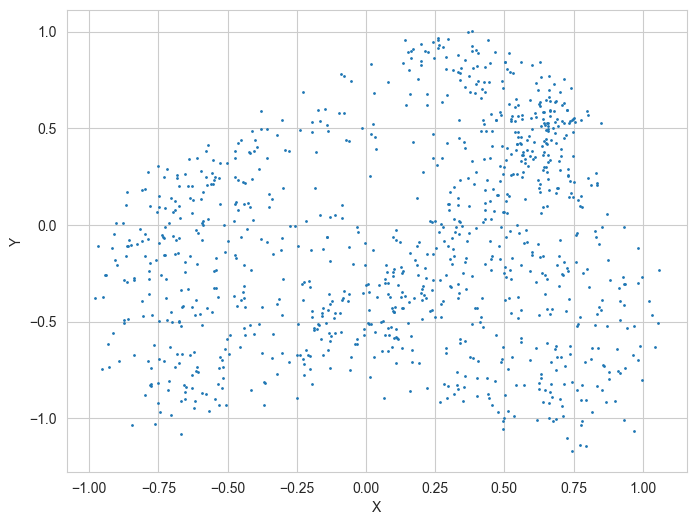

Epoch 151/1000: loss 0.1715 


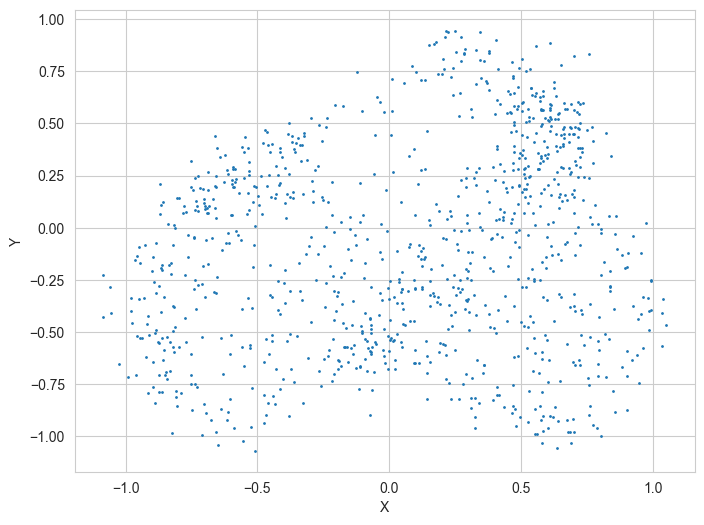

Epoch 201/1000: loss 0.1654 


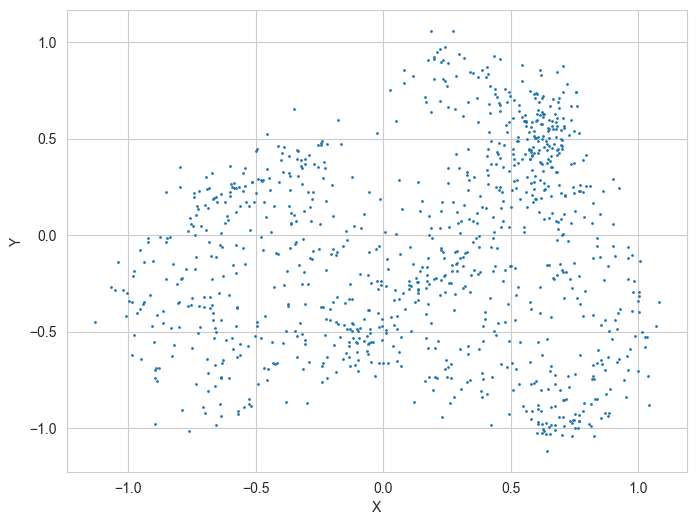

Epoch 251/1000: loss 0.1647 


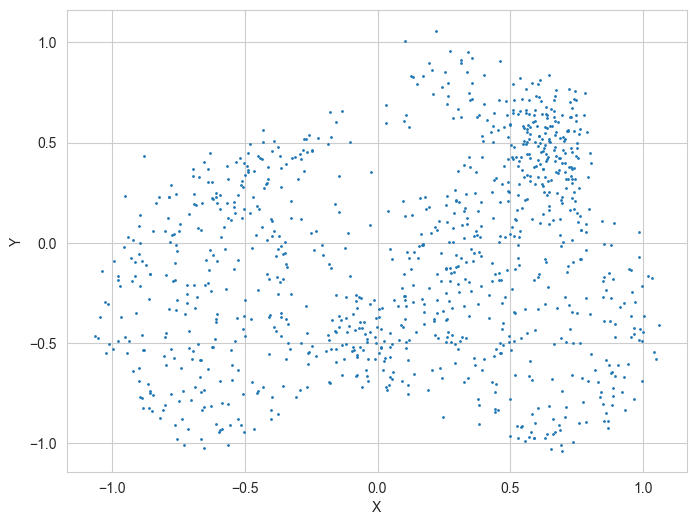

Epoch 301/1000: loss 0.1681 


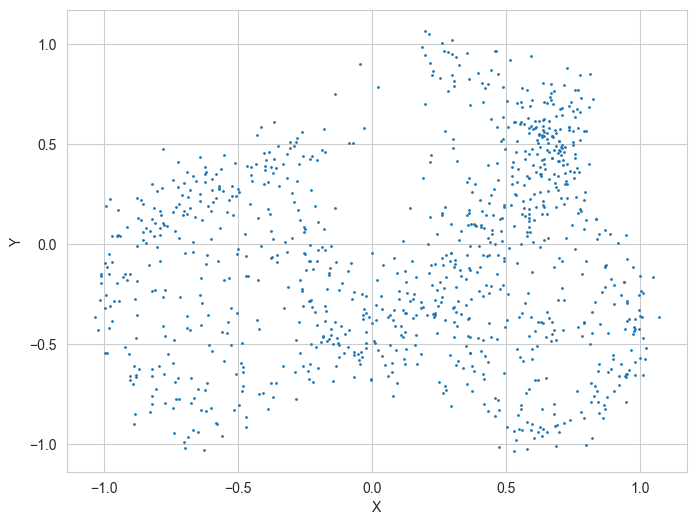

Epoch 351/1000: loss 0.1646 


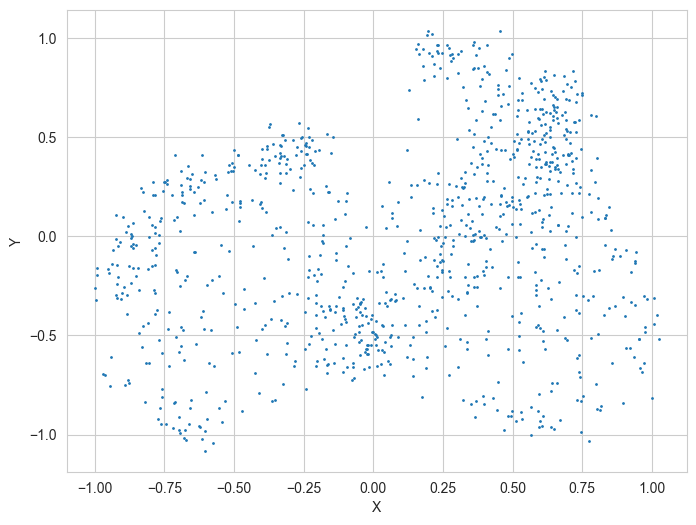

Epoch 401/1000: loss 0.1637 


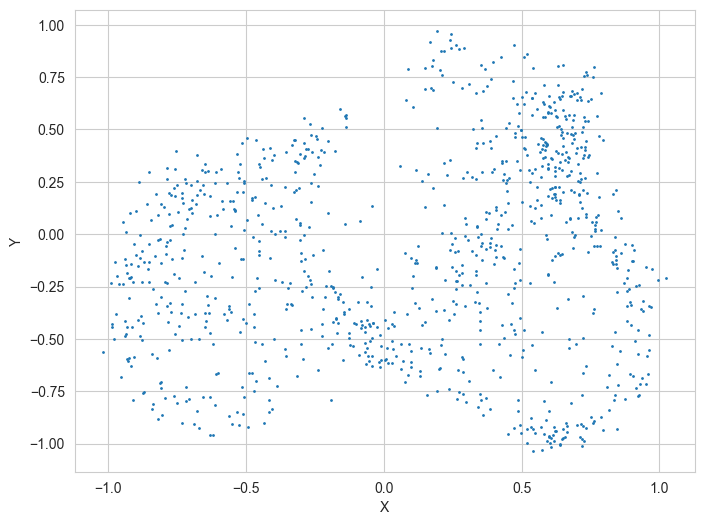

Epoch 451/1000: loss 0.1654 


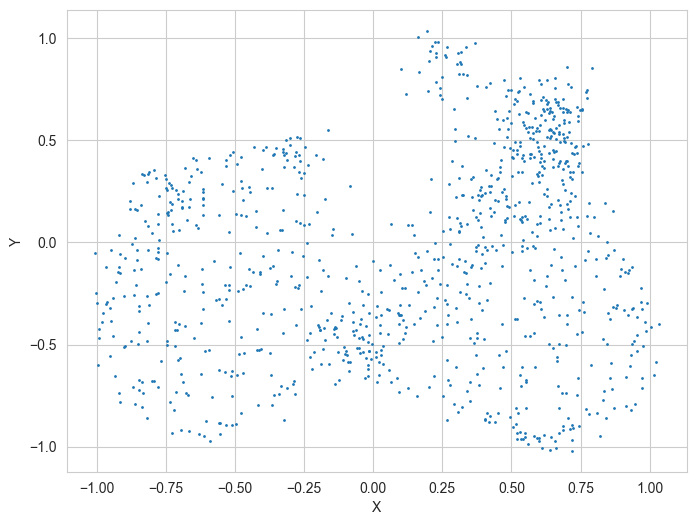

Epoch 501/1000: loss 0.1632 


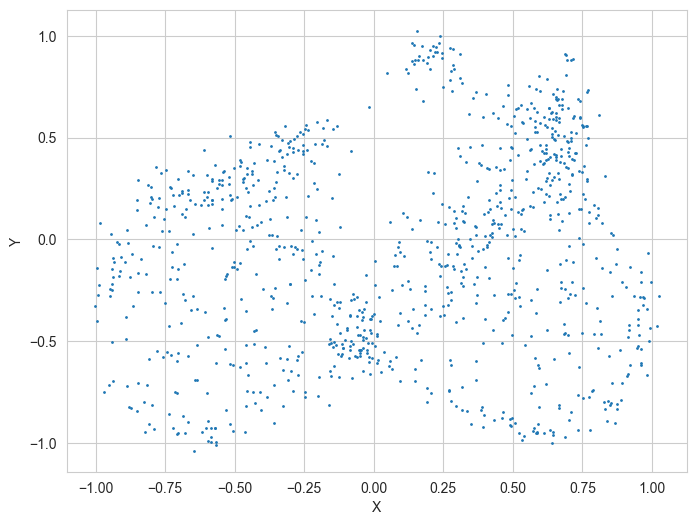

Epoch 551/1000: loss 0.1612 


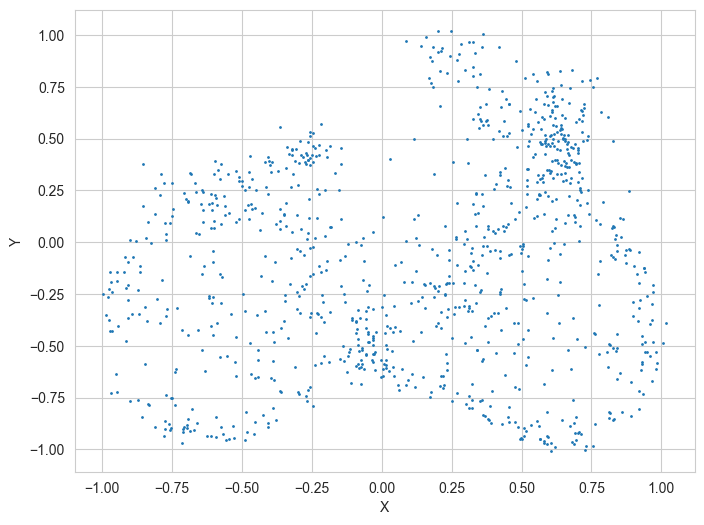

Epoch 601/1000: loss 0.1665 


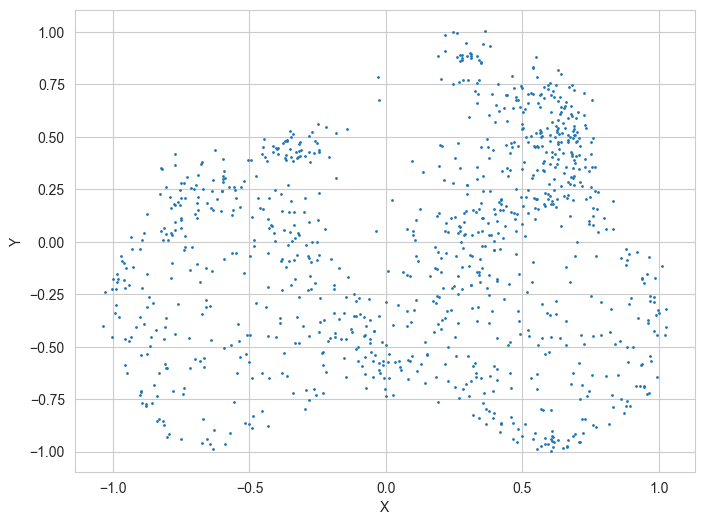

Epoch 651/1000: loss 0.1651 


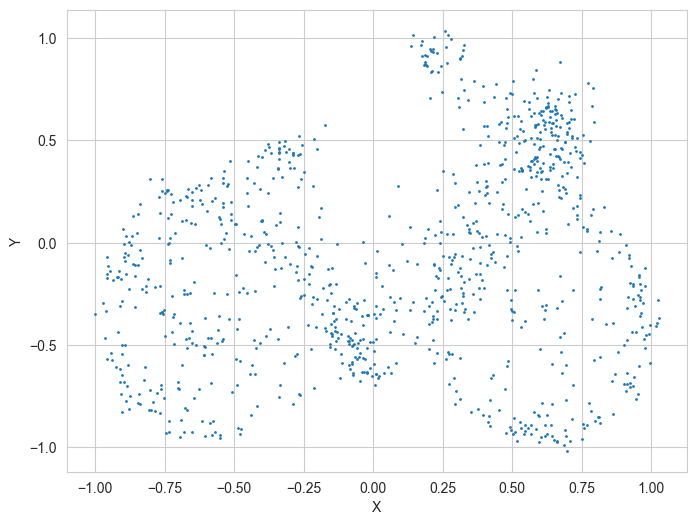

Epoch 701/1000: loss 0.1648 


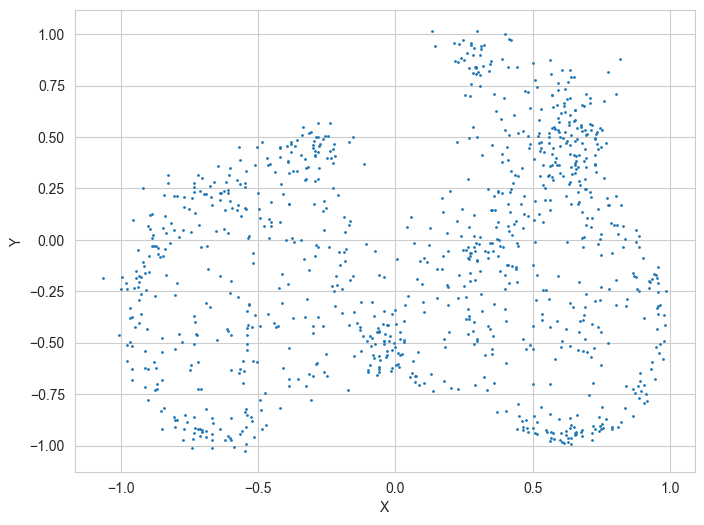

Epoch 751/1000: loss 0.1637 


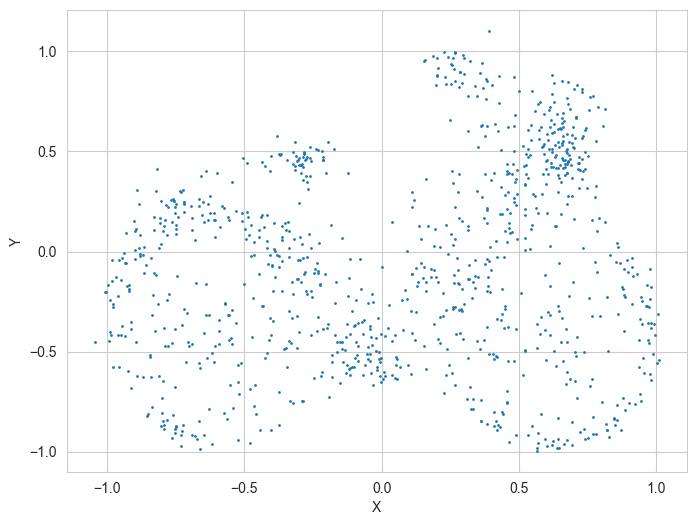

Epoch 801/1000: loss 0.1647 


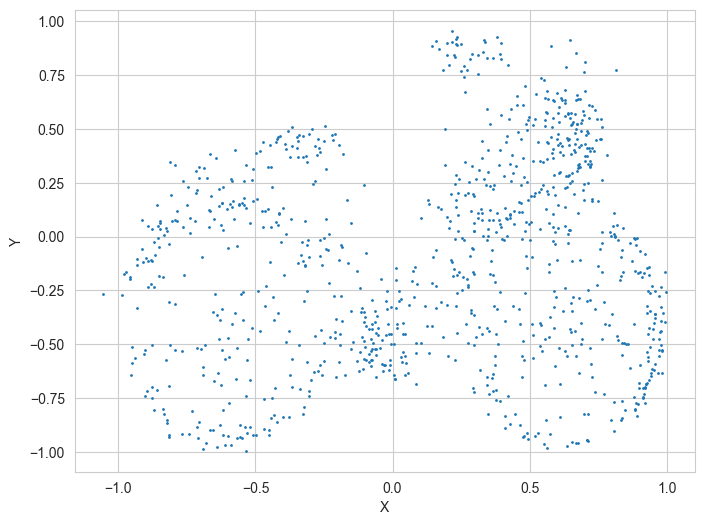

Epoch 851/1000: loss 0.1650 


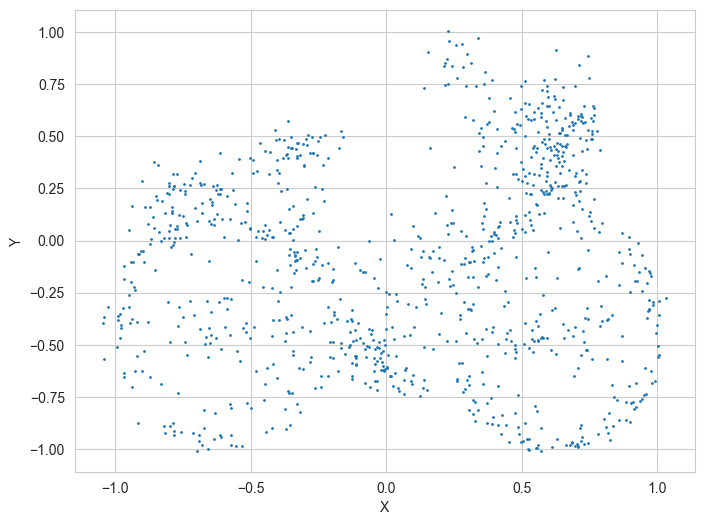

Epoch 901/1000: loss 0.1615 


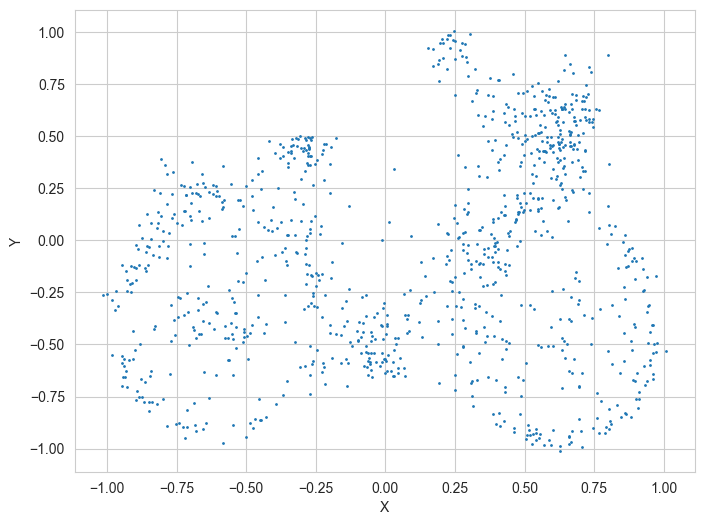

Epoch 951/1000: loss 0.1644 


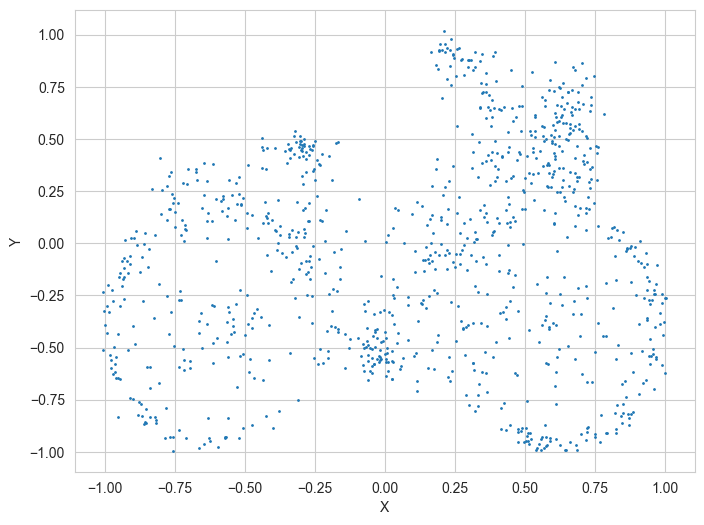

In [25]:
pbar = tqdm(total=epochs)
loss_history = []

for epoch in range(epochs):
    running_loss = 0
    for X_batch in train_loader:
        X_batch = X_batch.to(device)
        t = torch.randint(0, 1000, (X_batch.size(0),)).to(device)
        
        z = torch.randn_like(X_batch).to(device)
        
        eps = q(t, X_batch, z)
        eps_pred = model(eps, t)
        
        loss = loss_fn(eps_pred, z)
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss
            
    pbar.update(1)
    pbar.set_description(f"Loss: {running_loss:.4f}")

    running_loss = running_loss.item() / len(train_loader)
        
    if epoch % verbose == 0:
        print(f'Epoch {epoch+1}/{epochs}: loss {running_loss:.4f} ')\
        
        pred, _ = model.sample(1000)
        draw_points(pred.cpu())
        
        save_model(model, epoch)


In [26]:
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history, label="loss", color="blue")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.title("Training Loss History")
    plt.legend()
    plt.show()

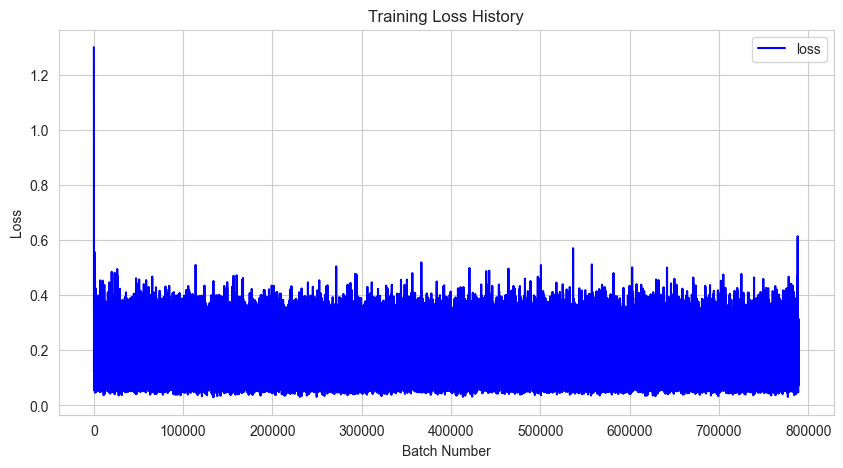

In [27]:
plot_training_history(loss_history)

In [28]:
pred, steps = model.sample(20000, True)

In [43]:
t_values = list(range(0, T+1, 100))
idx_to_plot = [0, 500, 750, 875, 950, 975, 987, 994, 997]
steps_to_plot = [steps[i] for i in idx_to_plot] + [pred.cpu()]
labels = [f"t={1000 - t}" for t in idx_to_plot + [999]]

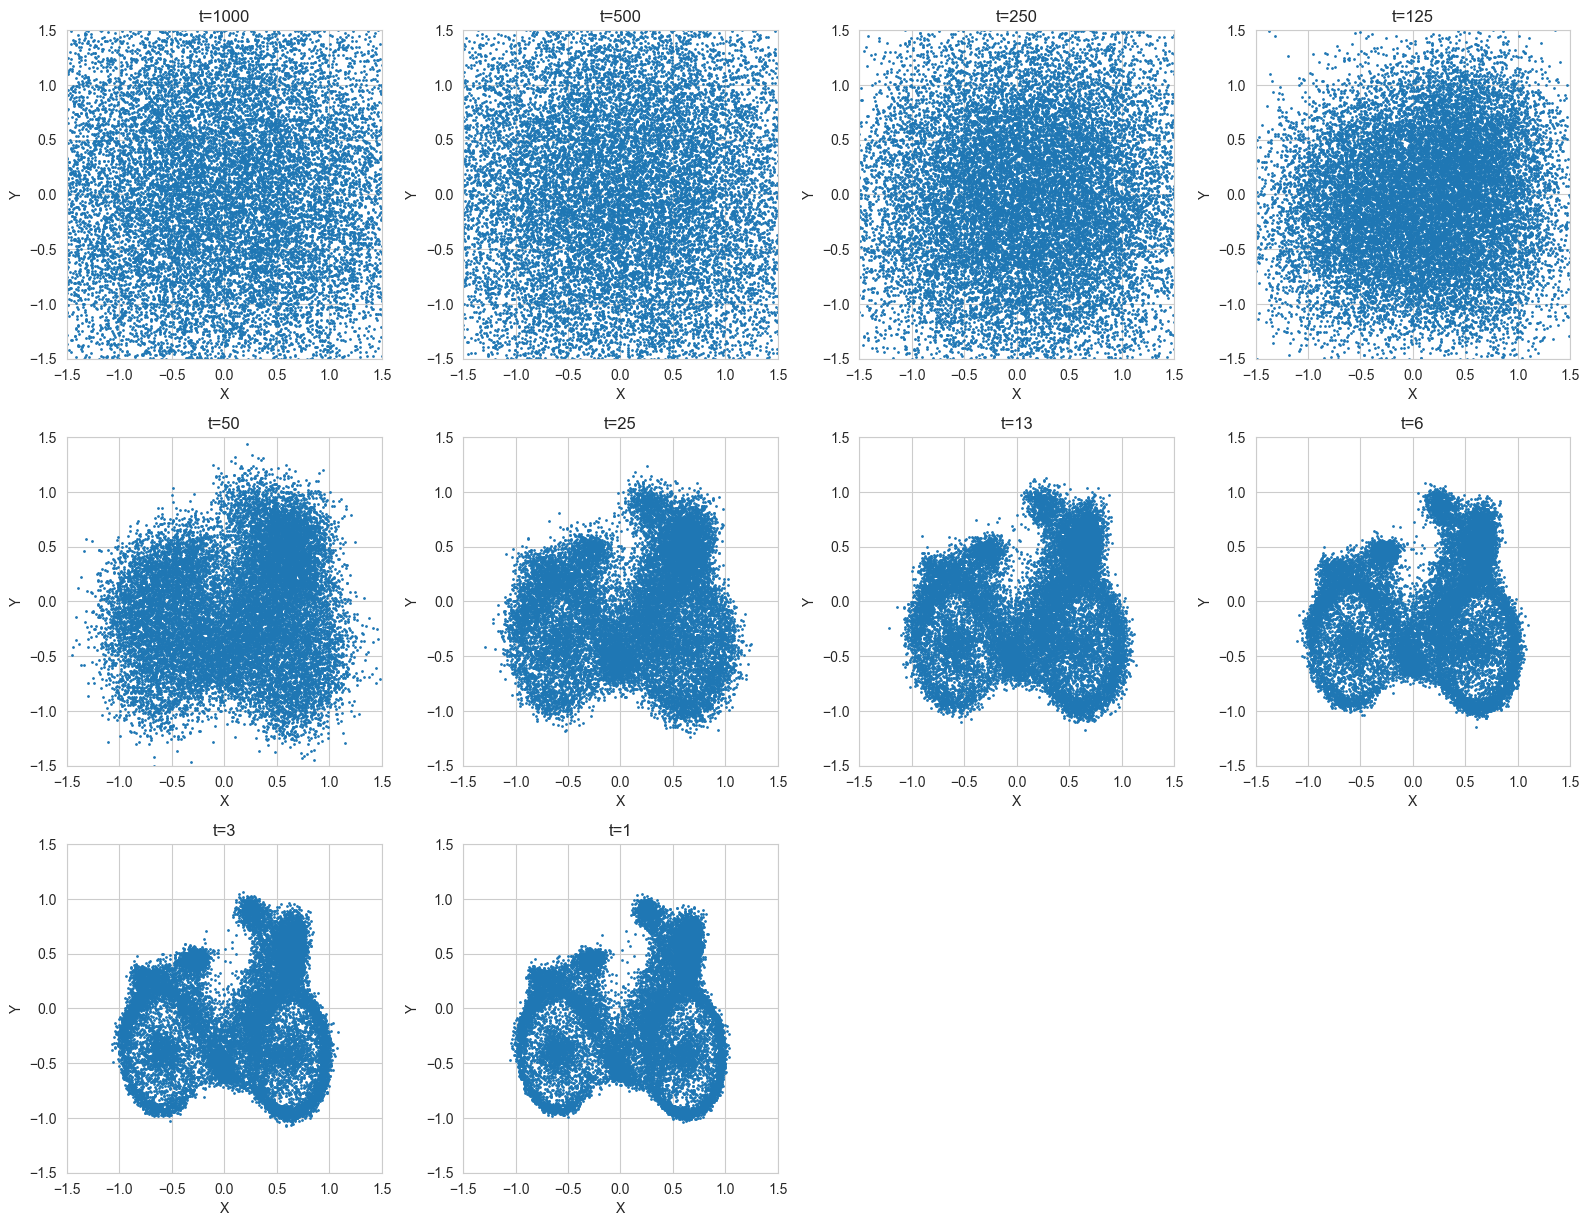

In [44]:
draw_multiple_stages(steps_to_plot, labels)

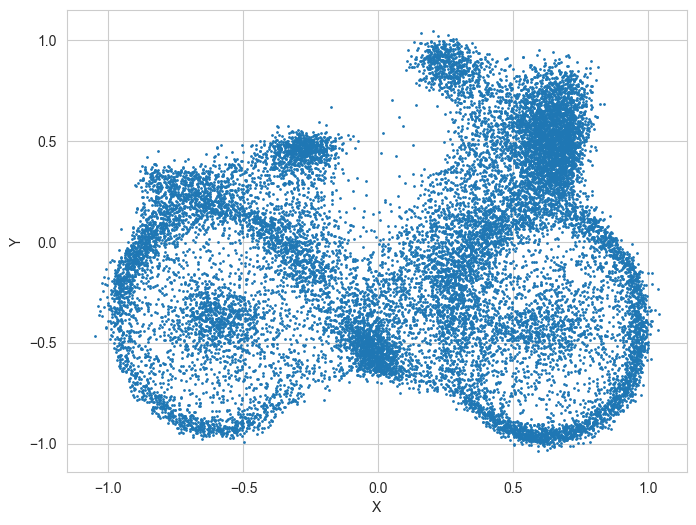

In [45]:
draw_points(pred)